In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import tensorflow as tf
print(tf.__version__)

2.16.1


In [4]:
import os
from os import listdir
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
# -----------------------
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
# -----------------------
import tensorflow as tf
from keras import Model
from tensorflow.keras import backend as K
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,InputLayer, Dense, Dropout, Flatten,ELU, PReLU, LeakyReLU,ThresholdedReLU,Reshape,GlobalAveragePooling2D,BatchNormalization, Lambda,Conv2D,MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from keras.callbacks import Callback, LearningRateScheduler
# -----------------------
from tqdm import tqdm
import shutil
import cv2
import itertools
from math import *
# -----------------------
import warnings
warnings.filterwarnings('ignore')

In [5]:
import os
from os import listdir
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
# -----------------------
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
# -----------------------
import tensorflow as tf
from keras import Model
from tensorflow.keras import backend as K
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,InputLayer, Dense, Dropout, Flatten,ELU, PReLU, LeakyReLU,ThresholdedReLU,Reshape,GlobalAveragePooling2D,BatchNormalization, Lambda,Conv2D,MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from keras.callbacks import Callback, LearningRateScheduler
# -----------------------
from tqdm import tqdm
import shutil
import cv2
import itertools
from math import *
# -----------------------
import warnings
warnings.filterwarnings('ignore')

## **2) Data Preprocessing**

### 2.1 Loading data

In [6]:
# Define image size
size = 299

# Create main directory and subdirectories if they don't already exist
if not os.path.exists('augmented'):
    os.mkdir('augmented')

if not os.path.exists('./augmented/benign'):
    os.mkdir('./augmented/benign')

if not os.path.exists('./augmented/malignant'):
    os.mkdir('./augmented/malignant')

print("Directories for augmented images created successfully.")


Directories for augmented images created successfully.


In [7]:
def getListOfFiles(dirName):
    listOfFile= os.listdir(dirName)
    allFiles= list()
    for entry in listOfFile:
        fullPath= os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles= allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
        
    return allFiles

In [8]:
files_benign = getListOfFiles('../input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign')
for f in files_benign:
    if f.endswith('.png'):
        shutil.copy(f, 'augmented/benign')

files_malignant = getListOfFiles('../input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant')
for f in files_malignant:
    if f.endswith('.png'):
        shutil.copy(f, 'augmented/malignant')

In [9]:
benign_images= getListOfFiles('augmented/benign')
malignant_images= getListOfFiles('./augmented/malignant')

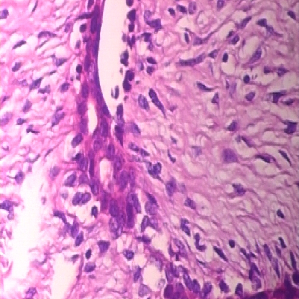

In [10]:
tf.keras.utils.load_img(benign_images[9], target_size=(size,size,1))

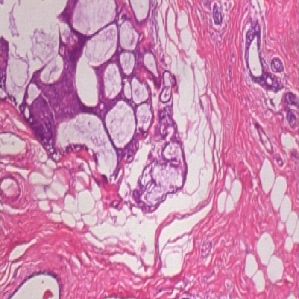

In [11]:
tf.keras.utils.load_img(malignant_images[45], target_size=(size,size,1))

In [12]:
# Checking the number of images
total_images = len(benign_images) + len(malignant_images)
total_images

7909

In [13]:
# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=(299, 299))  # Resize as needed
    img_array = tf.keras.utils.img_to_array(img)
    img_array /= 255.0  # Normalize the image
    return img_array

# Number of images to display
num_images_to_display = 8



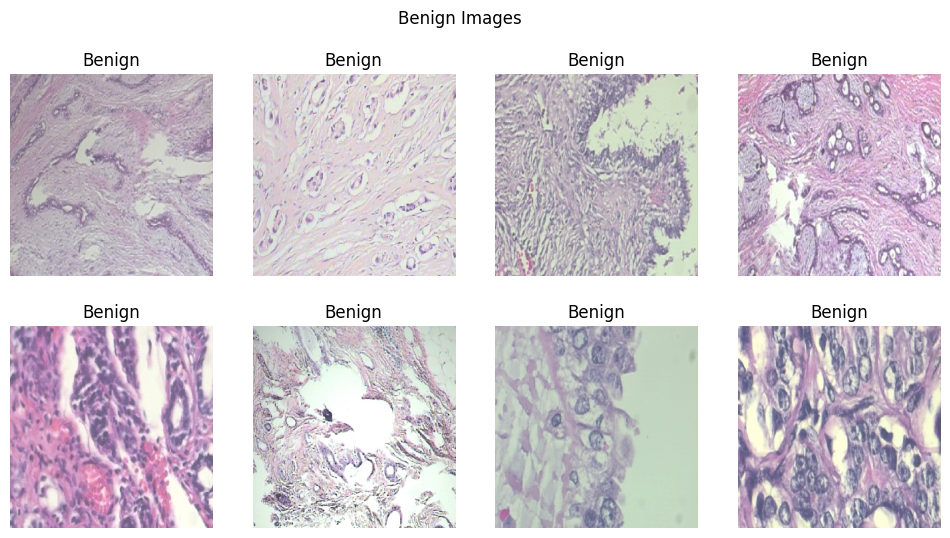

In [14]:
# Plot benign images
plt.figure(figsize=(12, 6))
for i in range(min(num_images_to_display, len(benign_images))):
    plt.subplot(2, 4, i + 1)
    img = load_and_preprocess_image(benign_images[i])
    plt.imshow(img)
    plt.title('Benign')
    plt.axis('off')

plt.suptitle('Benign Images')
plt.show()

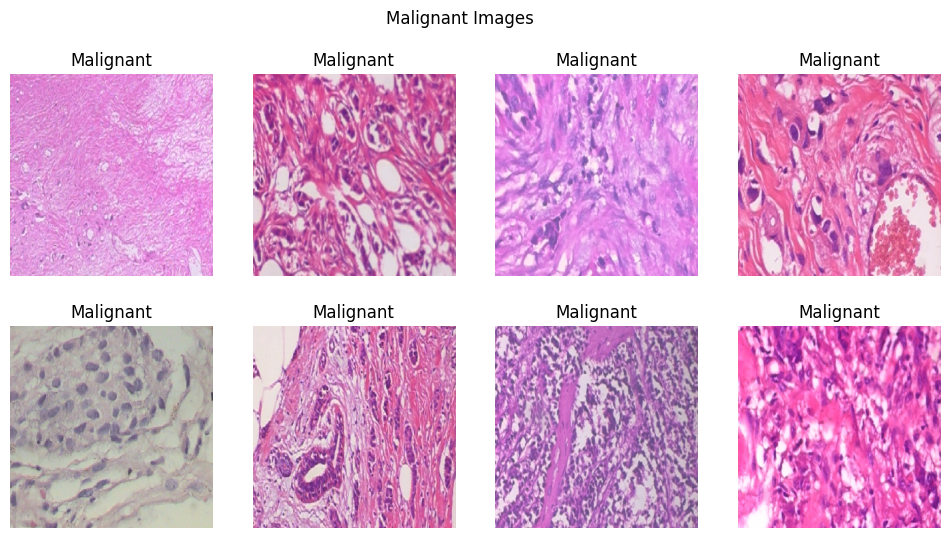

In [15]:
# Plot malignant images
plt.figure(figsize=(12, 6))
for i in range(min(num_images_to_display, len(malignant_images))):
    plt.subplot(2, 4, i + 1)
    img = load_and_preprocess_image(malignant_images[i])
    plt.imshow(img)
    plt.title('Malignant')
    plt.axis('off')

plt.suptitle('Malignant Images')
plt.show()


### 2.2 Creating the DataFrame

In [16]:
data = pd.DataFrame(index=np.arange(0, len(benign_images)+len(malignant_images)), columns=["image", "target"])
k=0
for c in [0,1]:
        if c==1:
            for m in range(len(benign_images)):
                data.iloc[k]["image"] = benign_images[m]
                data.iloc[k]["target"] = 'benign'
                k += 1
        else:
            for m in range(len(malignant_images)):
                data.iloc[k]["image"] = malignant_images[m]
                data.iloc[k]["target"] = 'malignant'
                k += 1
print(data.shape)
print(data.head())

(7909, 2)
                                               image     target
0  ./augmented/malignant/SOB_M_LC-14-15570-40-040...  malignant
1  ./augmented/malignant/SOB_M_DC-14-16336-100-00...  malignant
2  ./augmented/malignant/SOB_M_DC-14-14015-200-01...  malignant
3  ./augmented/malignant/SOB_M_LC-14-15570C-200-0...  malignant
4  ./augmented/malignant/SOB_M_MC-14-10147-400-00...  malignant


In [17]:
count_data = data["target"].value_counts()
count_data

target
malignant    5429
benign       2480
Name: count, dtype: int64

In [18]:
data.head()

,image,target
0,./augmented/malignant/SOB_M_LC-14-15570-40-040...,malignant
1,./augmented/malignant/SOB_M_DC-14-16336-100-00...,malignant
2,./augmented/malignant/SOB_M_DC-14-14015-200-01...,malignant
3,./augmented/malignant/SOB_M_LC-14-15570C-200-0...,malignant
4,./augmented/malignant/SOB_M_MC-14-10147-400-00...,malignant


In [19]:
# Split the dataset into training and validation sets
train_data_val, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['target'])

In [20]:
train_data_val['target']

2525    malignant
3199    malignant
6959       benign
2961    malignant
4471    malignant
          ...    
1985    malignant
304     malignant
1840    malignant
5327    malignant
1142    malignant
Name: target, Length: 6327, dtype: object

In [21]:
test_data['target']

1110    malignant
7611       benign
6638       benign
7792       benign
7837       benign
          ...    
3759    malignant
5691       benign
7127       benign
3858    malignant
374     malignant
Name: target, Length: 1582, dtype: object

In [22]:
# Resampling the bengin data to balance the data
ben_upsampled= resample(train_data_val[train_data_val['target']=='benign'], n_samples= train_data_val[train_data_val['target']=='malignant'].shape[0], random_state=42)
up_sampled = pd.concat([train_data_val[train_data_val['target']=='malignant'], ben_upsampled])
up_sampled['target'].value_counts()

target
malignant    4343
benign       4343
Name: count, dtype: int64

In [23]:
# Check data types
print(up_sampled.dtypes)

image     object
target    object
dtype: object


In [24]:
train_data, val_data= train_test_split(up_sampled,test_size=0.2,random_state=42, stratify=up_sampled['target']  )

In [25]:
train_data['target']

307     malignant
627     malignant
5932       benign
4851    malignant
6466       benign
          ...    
6750       benign
6251       benign
5596       benign
6964       benign
7153       benign
Name: target, Length: 6948, dtype: object

In [26]:
val_data['target']

293     malignant
7618       benign
5907       benign
3365    malignant
6095       benign
          ...    
1678    malignant
6563       benign
766     malignant
5571       benign
3645    malignant
Name: target, Length: 1738, dtype: object

### 2.3) Splitting the data

In [27]:
size=299
my_input= Input(shape=(size, size, 3))
img_shape=(size, size,3)

In [28]:
batch_size = 32
img_size = (299, 299)
data_gen= ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2),
                          rotation_range=40,
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          shear_range=0.2,
                          zoom_range=0.2,
                          horizontal_flip=True,
                          fill_mode='nearest')
ts_gen= ImageDataGenerator(rescale=1/255)

In [29]:
# Create the train generator
train_generator = data_gen.flow_from_dataframe(
    dataframe=train_data,
    x_col='image',  # Column with image paths
    y_col='target',  # Column with labels 
    target_size=img_size,  # Resize images
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=True
)

# Create the validation generator
val_generator = data_gen.flow_from_dataframe(
    dataframe=val_data,
    x_col='image',  # Column with image paths
    y_col='target',  # Column with labels 
    target_size=img_size,  # Resize images
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=False
)
test_generator= ts_gen.flow_from_dataframe(
    dataframe=test_data,
    x_col='image',  # Column with image paths
    y_col='target',  # Column with labels 
    target_size=img_size,  # Resize images
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=False
)

# Example to check output shapes
for x_batch, y_batch in train_generator:
    print(x_batch.shape, y_batch.shape)
    break  
    


Found 6948 validated image filenames belonging to 2 classes.
Found 1738 validated image filenames belonging to 2 classes.
Found 1582 validated image filenames belonging to 2 classes.
(32, 299, 299, 3) (32, 2)


In [30]:
for data in val_generator:
    print(data[0].shape, data[1].shape)  
    break  # Check only the first batch

(32, 299, 299, 3) (32, 2)


# **3) Model**

## **3.1) Pretrained model**
### (Xception)

In [31]:
input_shape = (299, 299, 3)  # Xception expects 299x299 images

model = Sequential()

# Add an InputLayer to define the input shape
model.add(InputLayer(input_shape=input_shape))

# Add the Xception model with ImageNet weights, excluding the top layer
model.add(tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=input_shape, pooling= 'max'))


model.add(Flatten()) 
model.add(Dropout(rate= 0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate= 0.25))
model.add(Dense(2, activation='softmax'))  # Output layer

# Compile the model
model.compile(Adamax(learning_rate= 0.001),
              loss= 'binary_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

# Display the model summary
model.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,010 (80.58 MB)

 Trainable params: 21,069,482 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

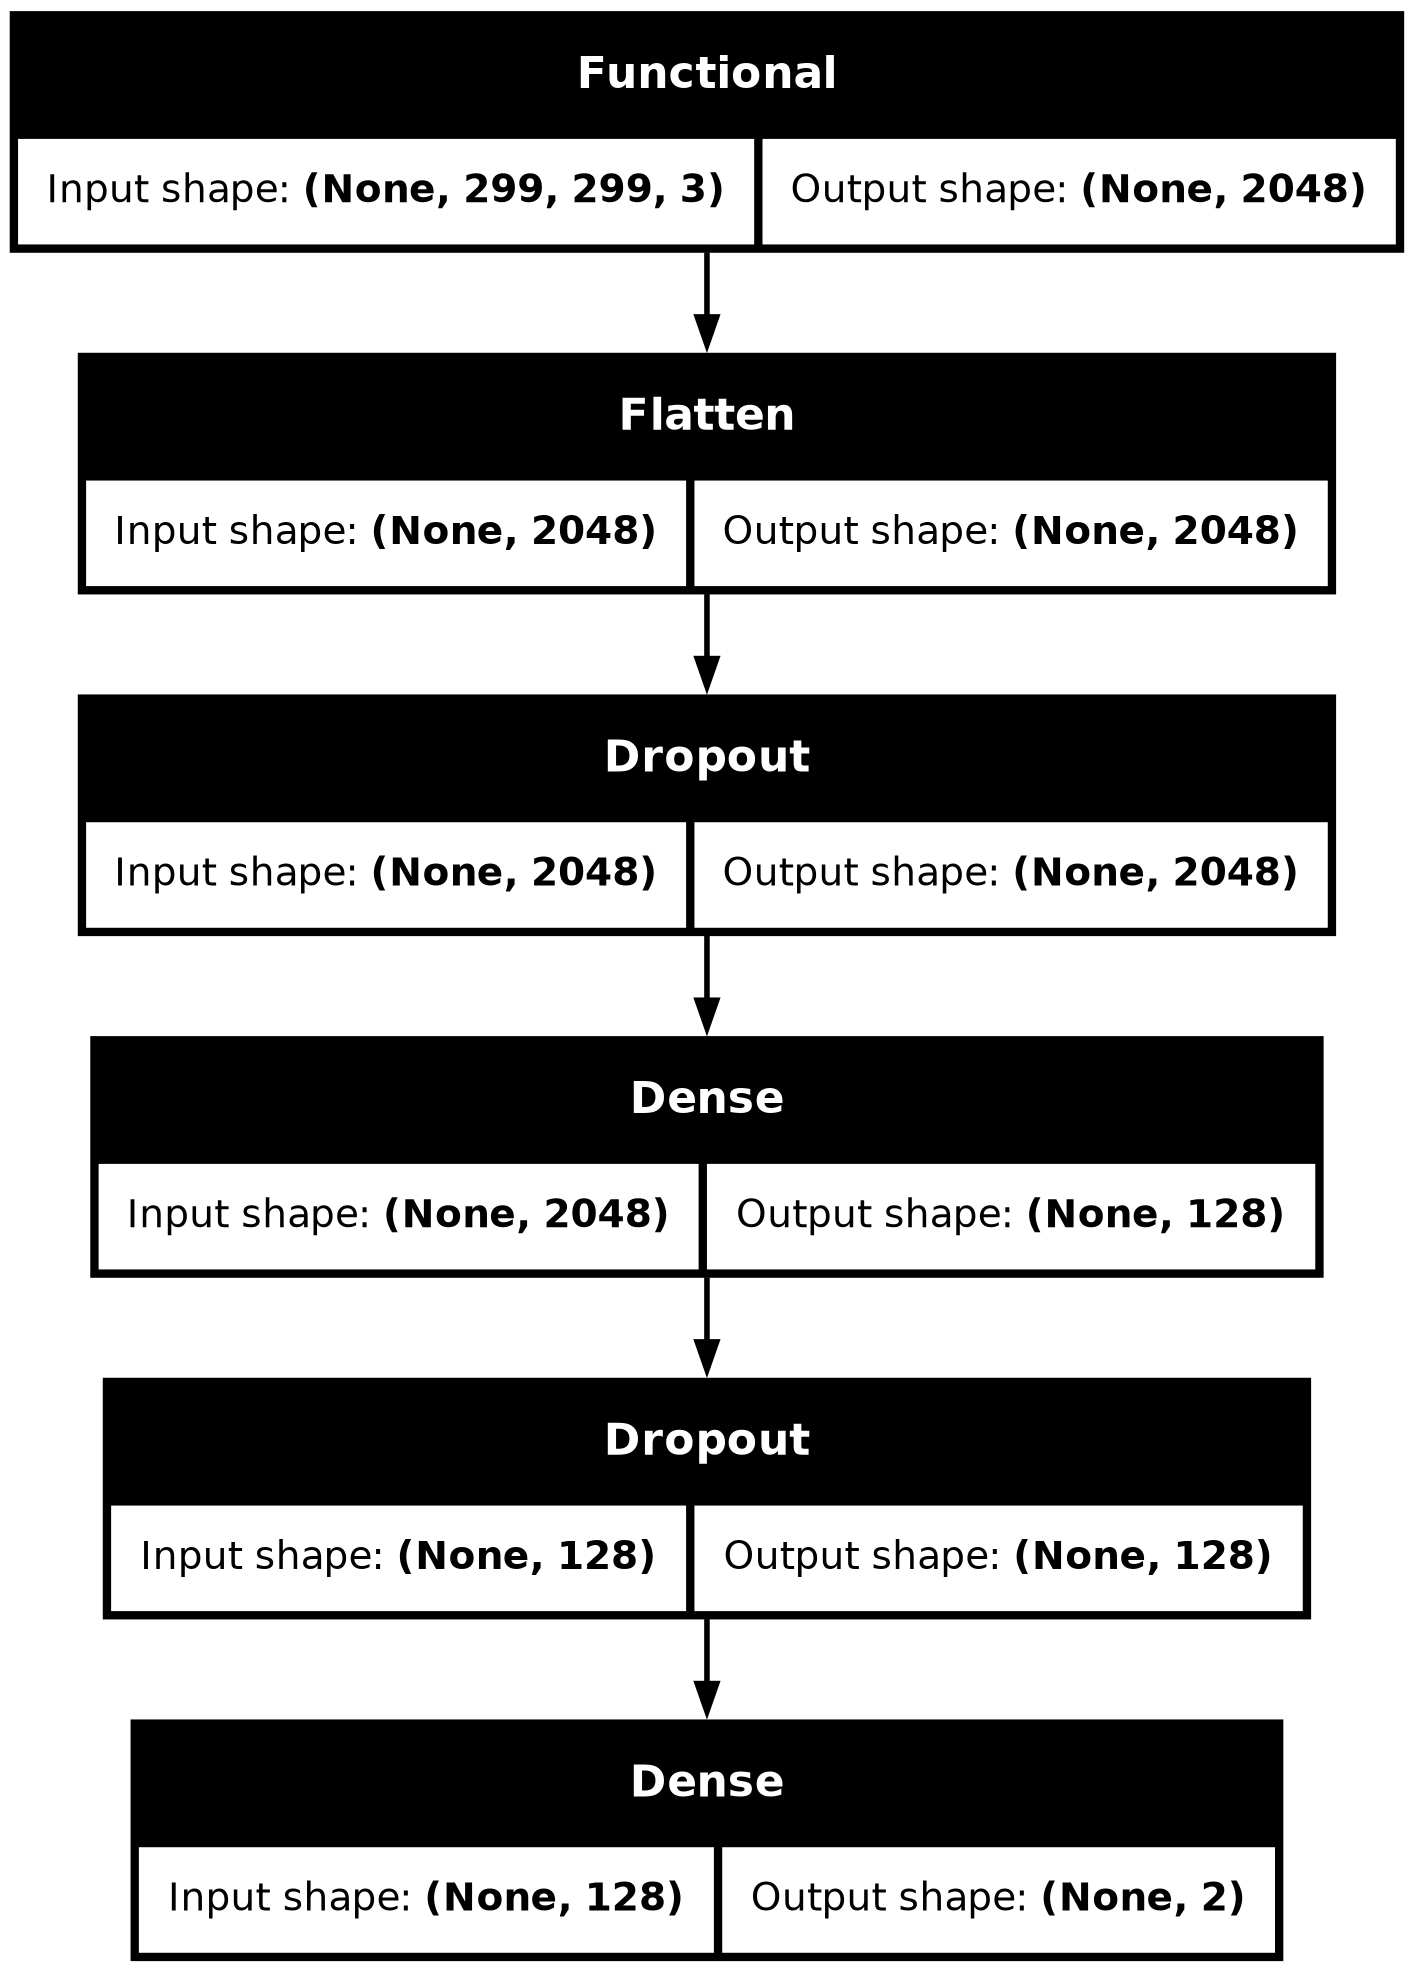

In [32]:
tf.keras.utils.plot_model(model, show_shapes=True)

# **WE WILL NOT RUN THE MODEL AGAIN**

In [33]:
hist = model.fit(train_generator,
                 epochs=10,
                 validation_data=val_generator,
                 shuffle= False)

Epoch 1/10


I0000 00:00:1730419526.701772     106 service.cc:145] XLA service 0x7a7690005aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730419526.702608     106 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730419526.702659     106 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1730419574.983333     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


218/218 ━━━━━━━━━━━━━━━━━━━━ 419s 2s/step - accuracy: 0.5118 - loss: 0.8045 - precision: 0.5118 - recall: 0.5118 - val_accuracy: 0.8142 - val_loss: 0.4952 - val_precision: 0.8142 - val_recall: 0.8142
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - accuracy: 0.8776 - loss: 0.3253 - precision: 0.8776 - recall: 0.8776 - val_accuracy: 0.9373 - val_loss: 0.1809 - val_precision: 0.9373 - val_recall: 0.9373
Epoch 3/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - accuracy: 0.9483 - loss: 0.1404 - precision: 0.9483 - recall: 0.9483 - val_accuracy: 0.9494 - val_loss: 0.1398 - val_precision: 0.9494 - val_recall: 0.9494
Epoch 4/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - accuracy: 0.9632 - loss: 0.1014 - precision: 0.9632 - recall: 0.9632 - val_accuracy: 0.9833 - val_loss: 0.0590 - val_precision: 0.9833 - val_recall: 0.9833
Epoch 5/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - accuracy: 0.9695 - loss: 0.0866 - precision: 0.9695 - recall: 0.9695 - val_accuracy: 0.9643 - val_loss: 0.1088 -

---
---
---

In [2]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/input/xception-breastcancer-model-h5/Xception_BreastCancer_model.h5')
hmxwaqam
wsjngfg

In [34]:
model.save('Xception_BreastCancer_model_xx.h5')  # Save both the architecture and weights
model.save('Xception_BreastCancer_model_Final_xx.keras')

In [35]:
# Convert the history object to a DataFrame
hist_df = pd.DataFrame(hist.history)

# Save the DataFrame to a CSV file
hist_df.to_csv('training_history.csv', index=False)

In [36]:
hist_df = pd.read_csv('/kaggle/input/history-scores/training_history.csv')
hist_df.head()

,accuracy,loss,precision,recall,val_accuracy,val_loss,val_precision,val_recall
0,0.696028,0.576261,0.696028,0.696028,0.807250,0.458398,0.807250,0.807250
1,0.924583,0.198331,0.924583,0.924583,0.945915,0.140983,0.945915,0.945915
2,0.957398,0.119389,0.957398,0.957398,0.957998,0.128077,0.957998,0.957998
3,0.969919,0.086544,0.969919,0.969919,0.964902,0.106257,0.964902,0.964902
4,0.970063,0.081483,0.970063,0.970063,0.972382,0.073147,0.972382,0.972382


In [37]:
#hist.history.keys()

## 4.1 Visualize model performance

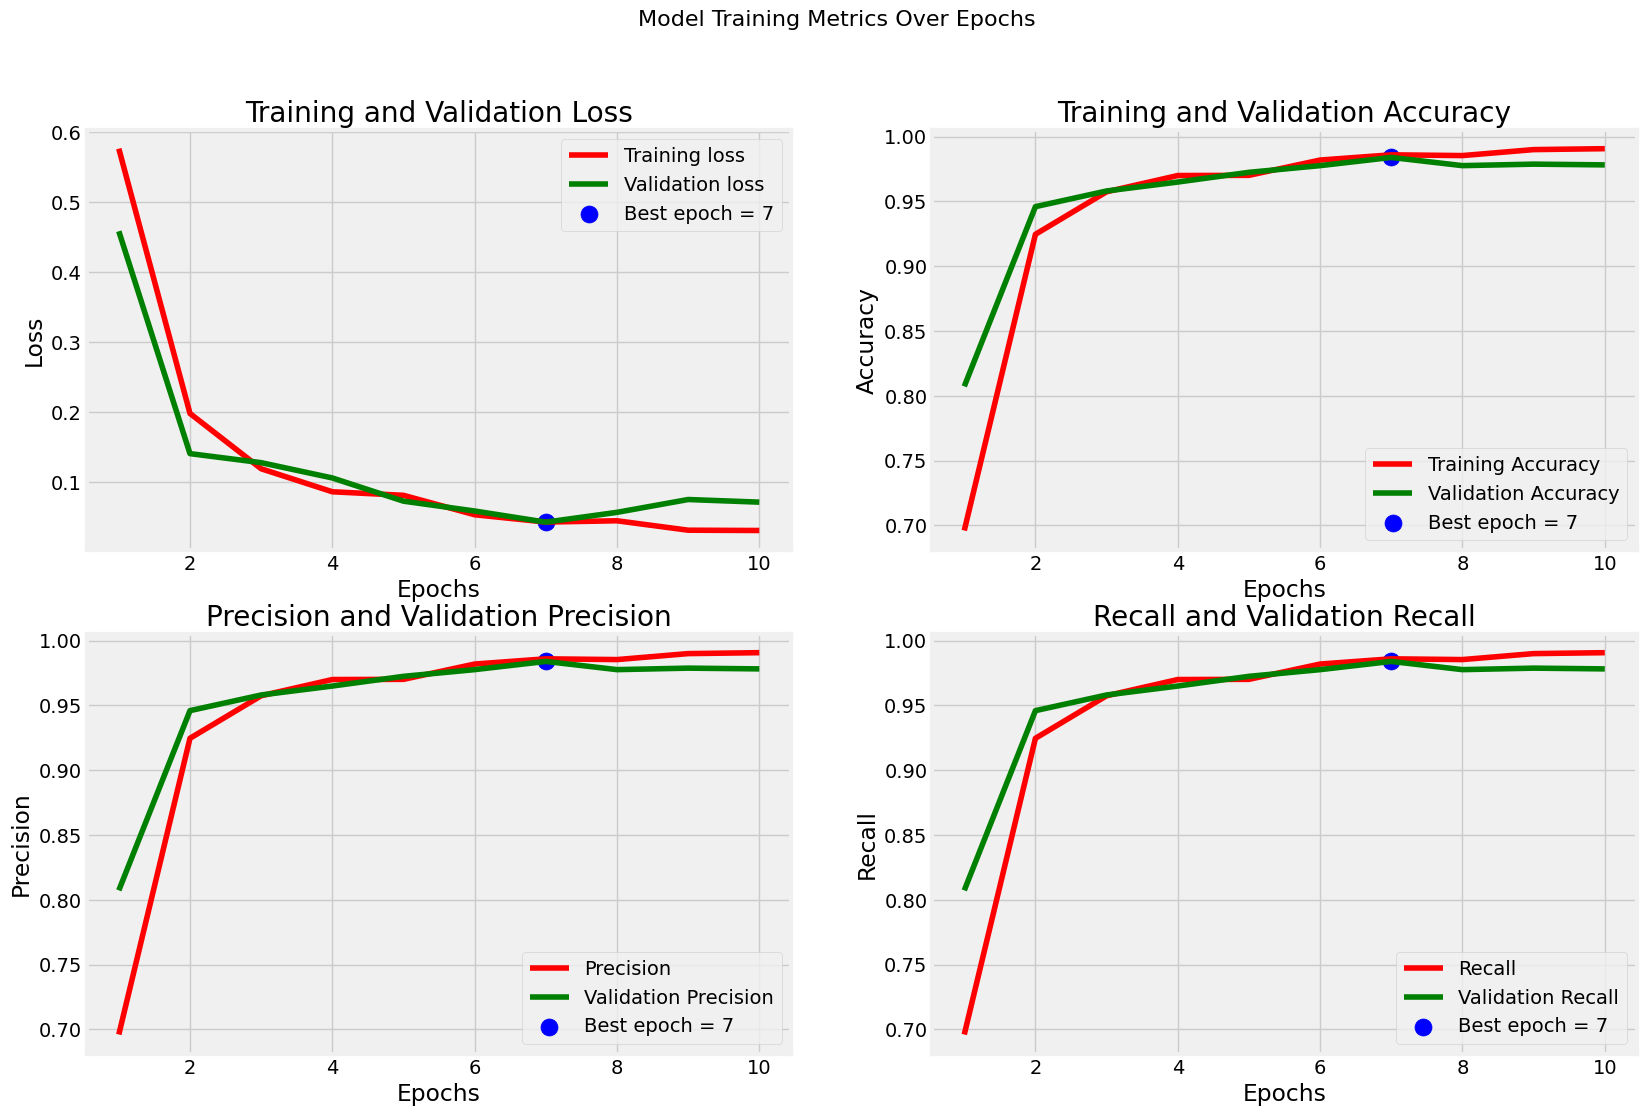

In [38]:
tr_acc = hist_df['accuracy']
tr_loss = hist_df['loss']
tr_per = hist_df['precision']
tr_recall = hist_df['recall']
val_acc = hist_df['val_accuracy']
val_loss = hist_df['val_loss']
val_per = hist_df['val_precision']
val_recall = hist_df['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.savefig("Model-Results.png")
plt.show()

# 5. Testing and Evaluation

## 5.1 Evaluate

In [39]:
train_score = model.evaluate(train_generator, verbose=1)
valid_score = model.evaluate(val_generator, verbose=1)
test_score = model.evaluate(test_generator, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")


218/218 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.9982 - loss: 0.0061 - precision: 0.9982 - recall: 0.9982
55/55 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9916 - loss: 0.0237 - precision: 0.9916 - recall: 0.9916
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 593ms/step - accuracy: 0.9861 - loss: 0.0432 - precision: 0.9861 - recall: 0.9861
Train Loss: 0.0071
Train Accuracy: 99.80%
--------------------
Validation Loss: 0.0204
Validation Accuracy: 99.25%
--------------------
Test Loss: 0.0465
Test Accuracy: 98.55%


In [40]:
# Create a DataFrame with the scores
scores_df = pd.DataFrame({
    'Metric': ['Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy', 'Test Loss', 'Test Accuracy'],
    'Score': [train_score[0], train_score[1], valid_score[0], valid_score[1], test_score[0], test_score[1]]
})

# Save the DataFrame to a CSV file
scores_df.to_csv('model_scores.csv', index=False)

print("Scores saved to model_scores.csv")


Scores saved to model_scores.csv


In [41]:
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)

50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 458ms/step


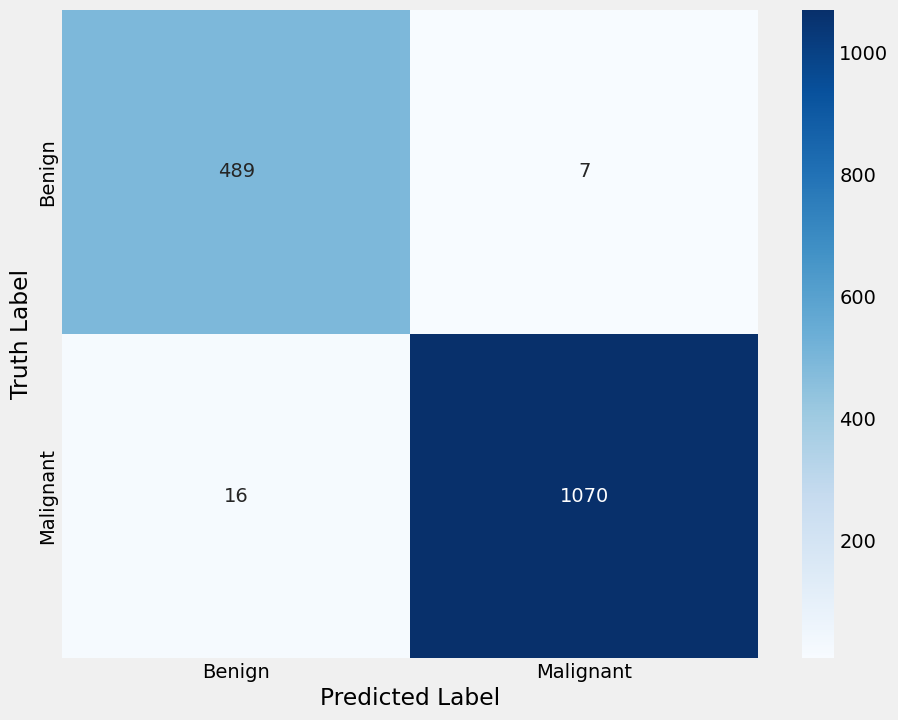

In [42]:
cm = confusion_matrix(test_generator.classes, y_pred)
labels = ['Benign', 'Malignant']
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [43]:
clr = classification_report(test_generator.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       496
           1       0.99      0.99      0.99      1086

    accuracy                           0.99      1582
   macro avg       0.98      0.99      0.98      1582
weighted avg       0.99      0.99      0.99      1582



## 5.2 Testing

In [44]:
def predict(img_path):
    label = ['Benign', 'Malignant'] 
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

In [45]:
test_data['image'].values

array(['./augmented/malignant/SOB_M_DC-14-14946-40-028.png',
       'augmented/benign/SOB_B_A-14-22549G-200-001.png',
       'augmented/benign/SOB_B_TA-14-3411F-40-002.png', ...,
       'augmented/benign/SOB_B_A-14-22549AB-100-014.png',
       './augmented/malignant/SOB_M_DC-14-2523-40-013.png',
       './augmented/malignant/SOB_M_MC-14-16456-100-070.png'],
      dtype=object)

['augmented/benign/SOB_B_F-14-23060CD-100-009.png']
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


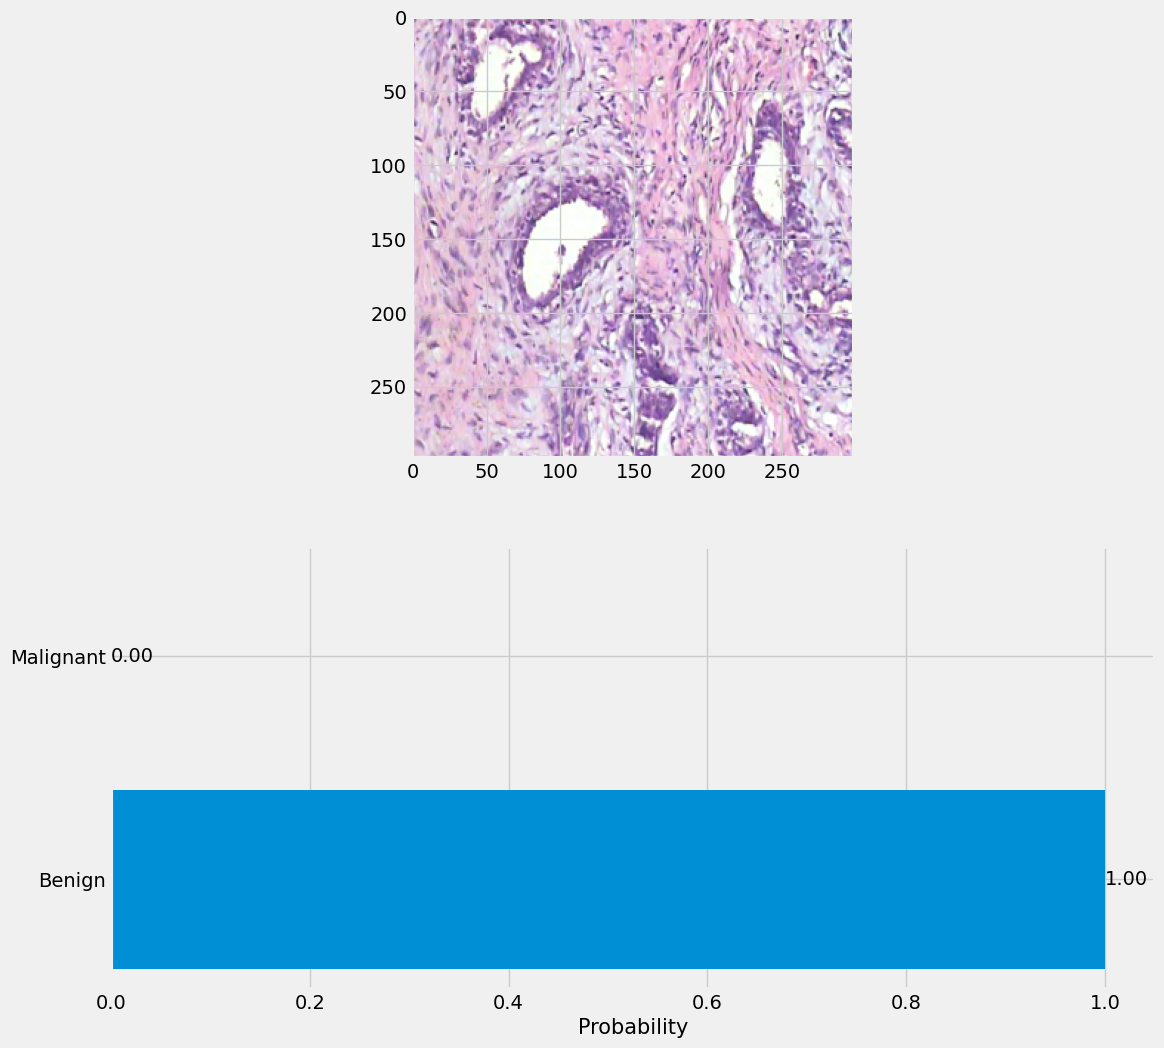

In [46]:
# Randomly select `1` elements from `test_data['image'].values`
random_image = np.random.choice(test_data['image'].values, size=1, replace=False)
print(random_image)
predict(random_image[0])